# **Image Super Resolution **


---



Image Super Resolution Using ESPCN(Efficient Sub-Pixel Convolution Network). BSDS500 dataset is used .


---

Dataset Link:-
https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html




Importing All libraries required for image super resolution

In [ ]:
import tensorflow as tf

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from IPython.display import display

Downloading dataset
We are using the wget utility to retrieve the dataset.

In [ ]:
! wget http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz

--2021-07-02 05:41:58--  http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www.eecs.berkeley.edu (www.eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8001::1, 2620:12a:8000::1
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2021-07-02 05:41:59--  https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2021-07-02 05:41:59--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www2.eecs.berkeley.edu (ww

Extracting dataset

In [ ]:
! tar zxvf BSR_bsds500.tgz

BSR/
BSR/documentation/
BSR/documentation/Arbelaez_Maire_Fowlkes_Malik_TPAMI2010.pdf
BSR/bench/
BSR/bench/source/
BSR/bench/source/match.hh
BSR/bench/source/Matrix.cc
BSR/bench/source/Timer.cc
BSR/bench/source/csa_types.h
BSR/bench/source/csa.cc
BSR/bench/source/correspondPixels.cc
BSR/bench/source/build.sh
BSR/bench/source/match.cc
BSR/bench/source/Sort.hh
BSR/bench/source/csa_defs.h
BSR/bench/source/Timer.hh
BSR/bench/source/Exception.cc
BSR/bench/source/String.cc
BSR/bench/source/Array.hh
BSR/bench/source/kofn.hh
BSR/bench/source/Random.hh
BSR/bench/source/Exception.hh
BSR/bench/source/.gitignore
BSR/bench/source/kofn.cc
BSR/bench/source/build.m
BSR/bench/source/Random.cc
BSR/bench/source/Point.hh
BSR/bench/source/README
BSR/bench/source/Matrix.hh
BSR/bench/source/csa.hh
BSR/bench/source/String.hh
BSR/bench/bench_bsds500.m
BSR/bench/data/
BSR/bench/data/groundTruth/
BSR/bench/data/groundTruth/6046.mat
BSR/bench/data/groundTruth/2018.mat
BSR/bench/data/groundTruth/8068.mat
BSR/bench/

We create training and validation datasets via image_dataset_from_directory.

In [ ]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 10


train_ds = image_dataset_from_directory(
    '/content/BSR/BSDS500/data',
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode = None
)

valid_ds = image_dataset_from_directory(
    '/content/BSR/BSDS500/data',
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=42, label_mode = None
)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


We normalize the images to take values in the range [0, 1].

In [ ]:
def normalise_img(img):
    img = img / 255.0
    return img

train_ds = train_ds.map(normalise_img)
valid_ds = valid_ds.map(normalise_img)

Visualization of sample images

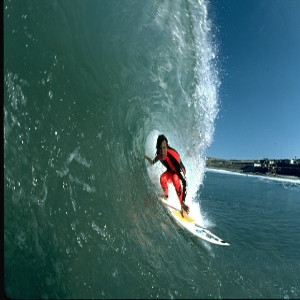

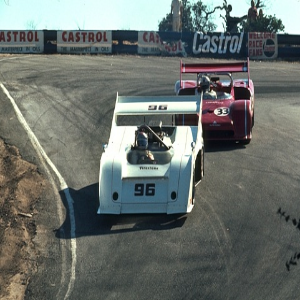

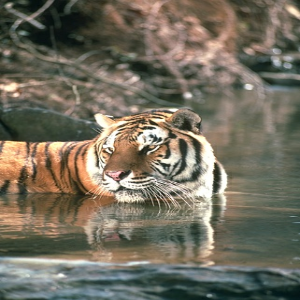

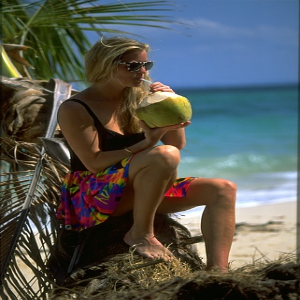

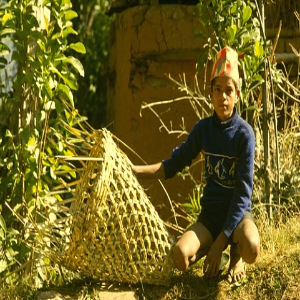

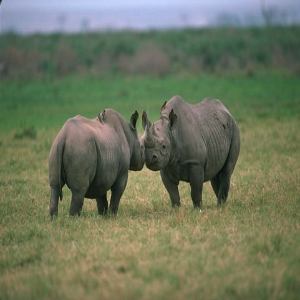

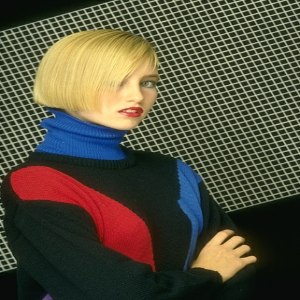

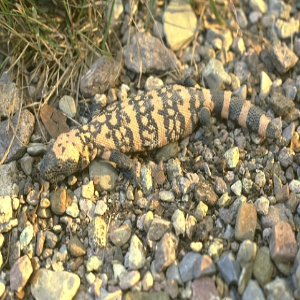

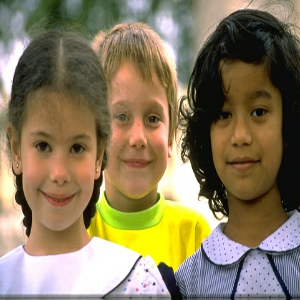

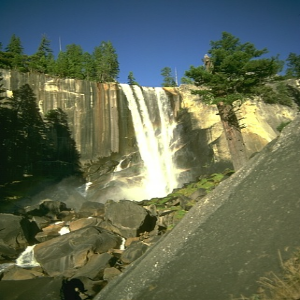

In [ ]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

Image Preprocessing

---


We convert images from the RGB color space to the YUV colour space.For the input data (low-resolution images), we crop the image, retrieve the y channel (luninance), and resize it with the area method (We are using bilinear method) We only consider the luminance channel in the YUV color space because humans are more sensitive to luminance change. For the target data (high-resolution images), we just crop the image and retrieve the y channel.

In [ ]:
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)

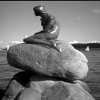

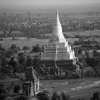

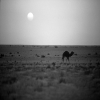

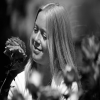

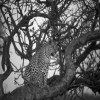

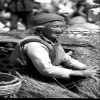

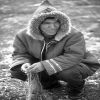

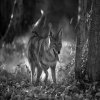

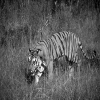

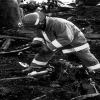

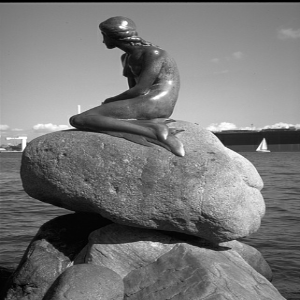

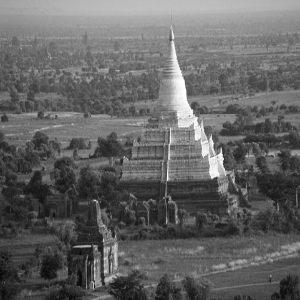

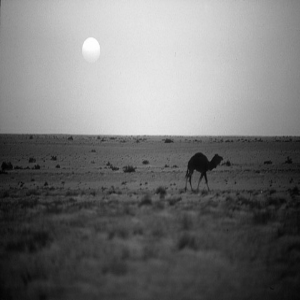

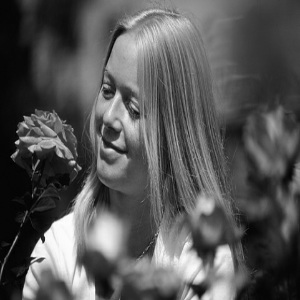

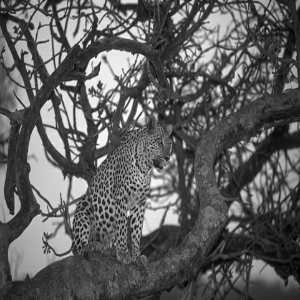

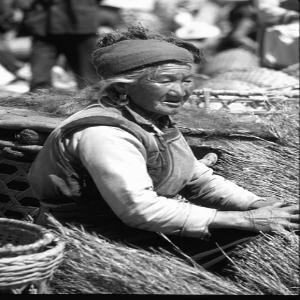

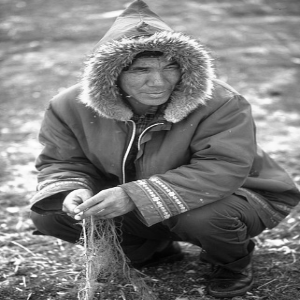

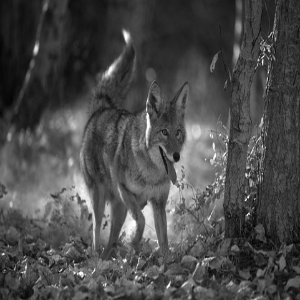

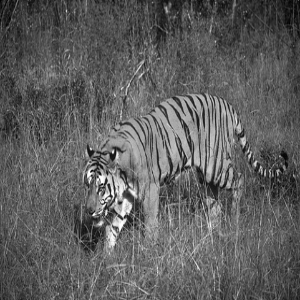

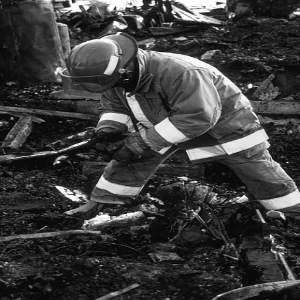

In [ ]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

Building the model

In [ ]:
channels = 1
inputs = keras.Input(shape=(None, None, channels))
x = layers.Conv2D(64, 5, padding='same', activation='tanh')(inputs)
x = layers.Conv2D(64, 3, padding='same', activation='tanh')(x)
x = layers.Conv2D(32, 3, padding='same', activation='tanh')(x)
x = layers.Conv2D(channels * (upscale_factor ** 2), 3, padding='same', activation='tanh')(x)
outputs = tf.nn.depth_to_space(x, upscale_factor)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
_________________________________________________________

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# some useful functions
def get_low_res_img(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )
def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

Peak Signal to Noise Ratio (PSNR)

In [ ]:
class ESPCNCallBack(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallBack, self).__init__()
        self.test_img = get_low_res_img(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [ ]:
# we also need to create a list of test images (with location) for inference model

test_img_paths = []
for file_name in os.listdir('/content/BSR/BSDS500/data/images/test/'):
  if file_name[-4:] == ".jpg":
    test_img_paths.append('/content/BSR/BSDS500/data/images/test/'+file_name)

test_img_paths.sort()    # 200 test images


In [ ]:
channels = 1
inputs = keras.Input(shape=(None, None, channels))
x = layers.Conv2D(64, 5, padding='same', activation='relu')(inputs)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(channels * (upscale_factor ** 2), 3, padding='same', activation='relu')(x)
outputs = tf.nn.depth_to_space(x, upscale_factor)

model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space_1 (TFOp (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
_______________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
40/40 - 33s - loss: 0.0614 - val_loss: 0.0328
Mean PSNR for epoch: 14.79


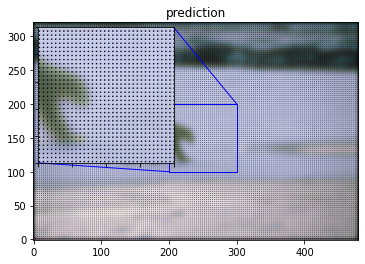

Epoch 2/200
40/40 - 2s - loss: 0.0250 - val_loss: 0.0079
Mean PSNR for epoch: 21.37
Epoch 3/200
40/40 - 2s - loss: 0.0067 - val_loss: 0.0050
Mean PSNR for epoch: 22.69
Epoch 4/200
40/40 - 2s - loss: 0.0049 - val_loss: 0.0040
Mean PSNR for epoch: 23.64
Epoch 5/200
40/40 - 2s - loss: 0.0039 - val_loss: 0.0034
Mean PSNR for epoch: 24.83
Epoch 6/200
40/40 - 2s - loss: 0.0036 - val_loss: 0.0032
Mean PSNR for epoch: 25.00
Epoch 7/200
40/40 - 2s - loss: 0.0033 - val_loss: 0.0030
Mean PSNR for epoch: 25.56
Epoch 8/200
40/40 - 2s - loss: 0.0030 - val_loss: 0.0028
Mean PSNR for epoch: 25.83
Epoch 9/200
40/40 - 2s - loss: 0.0029 - val_loss: 0.0027
Mean PSNR for epoch: 26.05
Epoch 10/200
40/40 - 2s - loss: 0.0029 - val_loss: 0.0027
Mean PSNR for epoch: 26.18
Epoch 11/200
40/40 - 2s - loss: 0.0028 - val_loss: 0.0027
Mean PSNR for epoch: 25.88
Epoch 12/200
40/40 - 2s - loss: 0.0028 - val_loss: 0.0027
Mean PSNR for epoch: 25.66
Epoch 13/200
40/40 - 2s - loss: 0.0028 - val_loss: 0.0026
Mean PSNR for e

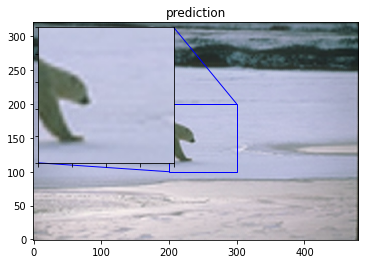

Epoch 22/200
40/40 - 2s - loss: 0.0027 - val_loss: 0.0026
Mean PSNR for epoch: 26.10
Epoch 23/200
40/40 - 2s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.80
Epoch 24/200
40/40 - 2s - loss: 0.0027 - val_loss: 0.0026
Mean PSNR for epoch: 25.84
Epoch 25/200
40/40 - 2s - loss: 0.0027 - val_loss: 0.0025
Mean PSNR for epoch: 26.26
Epoch 26/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR for epoch: 26.34
Epoch 27/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR for epoch: 26.10
Epoch 28/200
40/40 - 2s - loss: 0.0027 - val_loss: 0.0026
Mean PSNR for epoch: 26.04
Epoch 29/200
40/40 - 2s - loss: 0.0027 - val_loss: 0.0025
Mean PSNR for epoch: 25.49
Epoch 30/200
40/40 - 2s - loss: 0.0027 - val_loss: 0.0025
Mean PSNR for epoch: 26.36
Epoch 31/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR for epoch: 26.25
Epoch 32/200
40/40 - 2s - loss: 0.0027 - val_loss: 0.0025
Mean PSNR for epoch: 26.04
Epoch 33/200
40/40 - 2s - loss: 0.0027 - val_loss: 0.0026
Mean PS

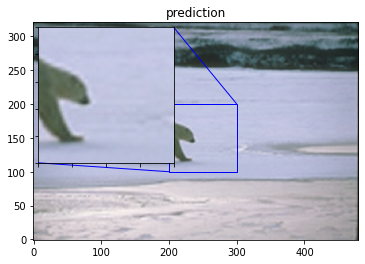

Epoch 42/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR for epoch: 26.02
Epoch 43/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR for epoch: 26.27
Epoch 44/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR for epoch: 26.09
Epoch 45/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR for epoch: 26.13
Epoch 46/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR for epoch: 26.51
Epoch 47/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0026
Mean PSNR for epoch: 25.71
Epoch 48/200
40/40 - 2s - loss: 0.0028 - val_loss: 0.0026
Mean PSNR for epoch: 25.86
Epoch 49/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR for epoch: 26.23
Epoch 50/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0026
Mean PSNR for epoch: 26.15
Epoch 51/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR for epoch: 25.76
Epoch 52/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR for epoch: 26.03
Epoch 53/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Mean PS

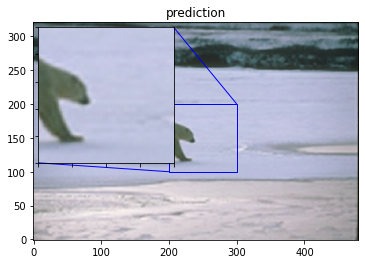

Epoch 62/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR for epoch: 26.04
Epoch 63/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR for epoch: 26.08
Epoch 64/200
40/40 - 2s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.43
Epoch 65/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR for epoch: 26.20
Epoch 66/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.26
Epoch 67/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR for epoch: 26.04
Epoch 68/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.33
Epoch 69/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 25.95
Epoch 70/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.03
Epoch 71/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.75
Epoch 72/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR for epoch: 25.81
Epoch 73/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0025
Mean PS

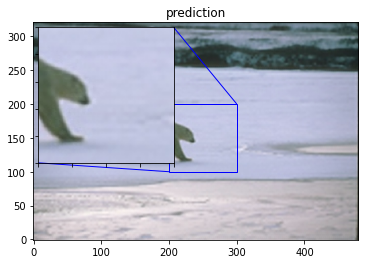

Epoch 82/200
40/40 - 2s - loss: 0.0034 - val_loss: 0.0026
Mean PSNR for epoch: 26.43
Epoch 83/200
40/40 - 2s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.38
Epoch 84/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 25.95
Epoch 85/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.23
Epoch 86/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.28
Epoch 87/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.41
Epoch 88/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 25.98
Epoch 89/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.20
Epoch 90/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.43
Epoch 91/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.31
Epoch 92/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.43
Epoch 93/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PS

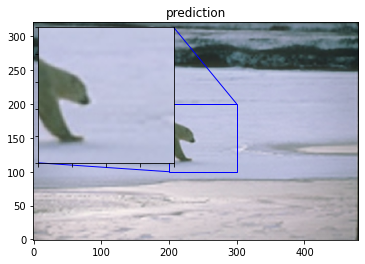

Epoch 102/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.39
Epoch 103/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 25.84
Epoch 104/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0026
Mean PSNR for epoch: 26.19
Epoch 105/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.63
Epoch 106/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.19
Epoch 107/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.17
Epoch 108/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.40
Epoch 109/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.73
Epoch 110/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0032
Mean PSNR for epoch: 25.10
Epoch 111/200
40/40 - 2s - loss: 0.0029 - val_loss: 0.0025
Mean PSNR for epoch: 26.74
Epoch 112/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.29
Epoch 113/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.

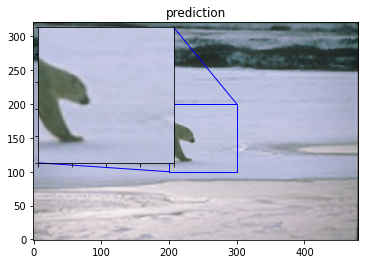

Epoch 122/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 25.86
Epoch 123/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.57
Epoch 124/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR for epoch: 26.47
Epoch 125/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.52
Epoch 126/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.41
Epoch 127/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 25.79
Epoch 128/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.04
Epoch 129/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 25.88
Epoch 130/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.49
Epoch 131/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR for epoch: 26.01
Epoch 132/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.06
Epoch 133/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.

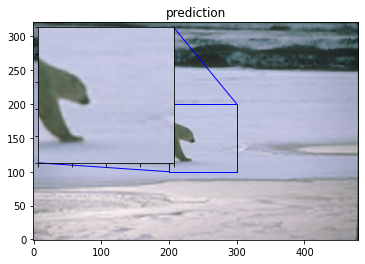

Epoch 142/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.60
Epoch 143/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.46
Epoch 144/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.66
Epoch 145/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.48
Epoch 146/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.07
Epoch 147/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.09
Epoch 148/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.74
Epoch 149/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.67
Epoch 150/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.77
Epoch 151/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.59
Epoch 152/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.48
Epoch 153/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.

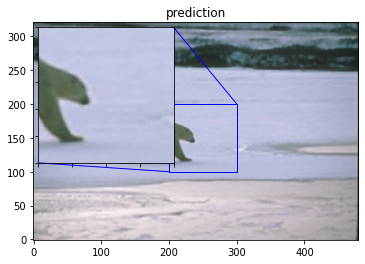

Epoch 162/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.75
Epoch 163/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.33
Epoch 164/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.91
Epoch 165/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.40
Epoch 166/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 25.94
Epoch 167/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.65
Epoch 168/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.53
Epoch 169/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.38
Epoch 170/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.45
Epoch 171/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.45
Epoch 172/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 25.88
Epoch 173/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.

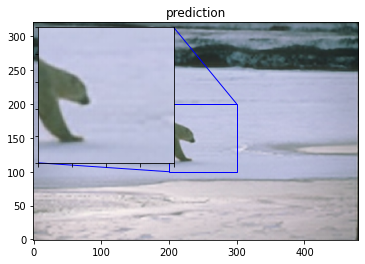

Epoch 182/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.11
Epoch 183/200
40/40 - 2s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.04
Epoch 184/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 25.37
Epoch 185/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.11
Epoch 186/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.21
Epoch 187/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.68
Epoch 188/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.76
Epoch 189/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.47
Epoch 190/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 25.75
Epoch 191/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 25.56
Epoch 192/200
40/40 - 2s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR for epoch: 26.17
Epoch 193/200
40/40 - 2s - loss: 0.0025 - val_loss: 0.

In [ ]:
epochs = 200
! mkdir -p "/tmp/checkpoint/model2"
# we also need to save the model while training so as to make predictions later on
checkpoint_filepath2 = "/tmp/checkpoint/model2"  # directory where model wts will be saved


model2.compile(
    optimizer=keras.optimizers.Adam(lr = .001), loss=keras.losses.MeanSquaredError())

model2.fit(
    train_ds, epochs=epochs, validation_data=valid_ds, verbose = 2, callbacks = [ESPCNCallBack(), keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_filepath2,
        save_weights_only=True,
        monitor="loss",
        mode="min",
        save_best_only=True,   # we will only save the best model, best => min MSE loss
    )]
)


In [ ]:
# Loading the "best" model that was achieved during training
model2.load_weights(checkpoint_filepath2)
# Save the entire model as a SavedModel, so that we can download it and dont need to retrain again and again
!mkdir -p saved_model
model2.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


PSNR of predict and high resolution is 24.438


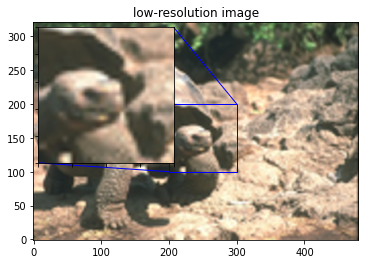

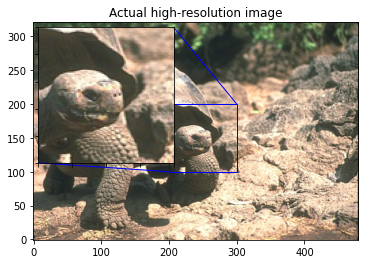

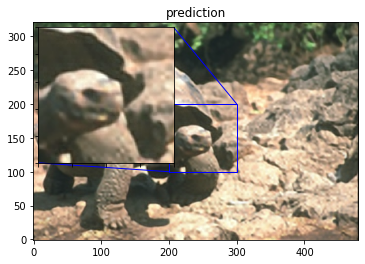

PSNR of predict and high resolution is 34.466


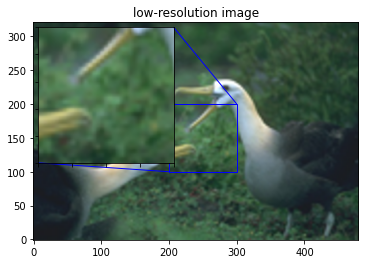

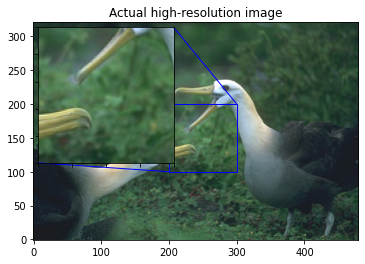

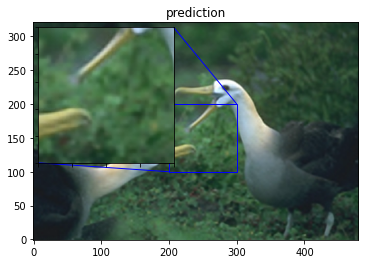

PSNR of predict and high resolution is 27.050


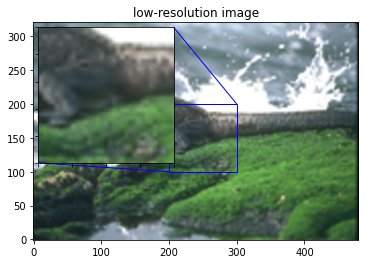

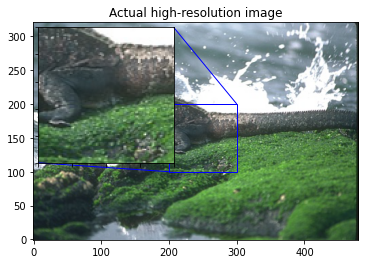

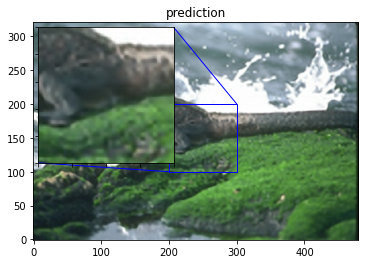

PSNR of predict and high resolution is 28.388


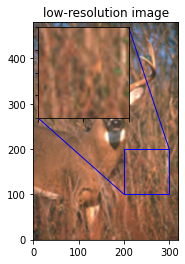

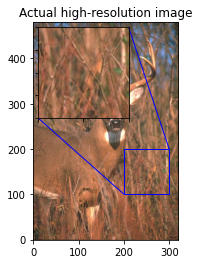

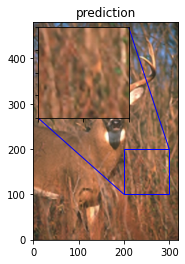

PSNR of predict and high resolution is 31.984


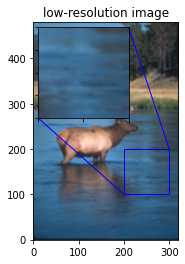

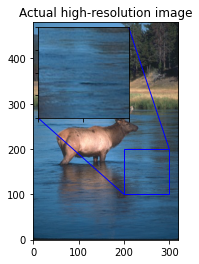

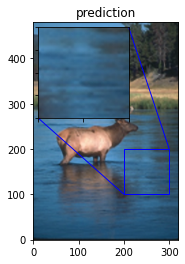

PSNR of predict and high resolution is 29.049


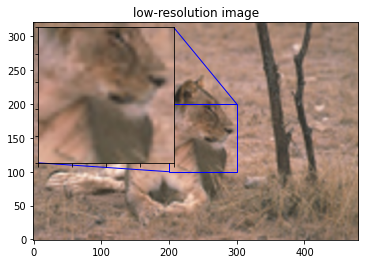

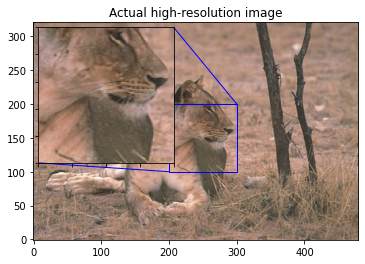

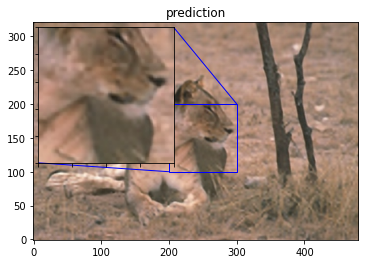

PSNR of predict and high resolution is 33.665


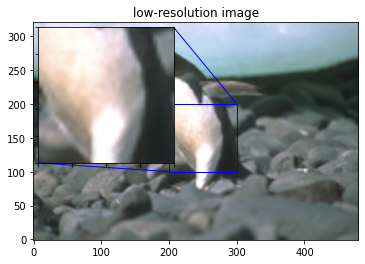

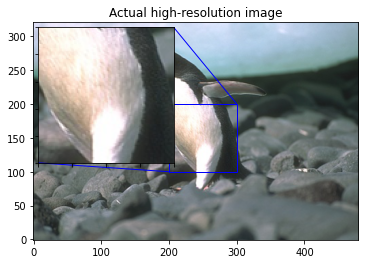

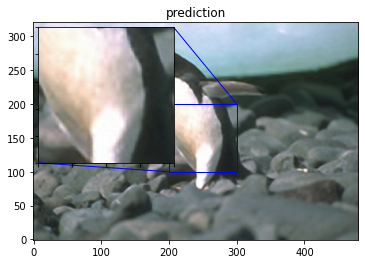

PSNR of predict and high resolution is 32.685


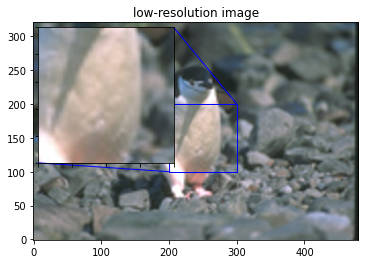

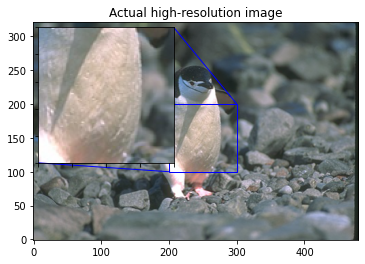

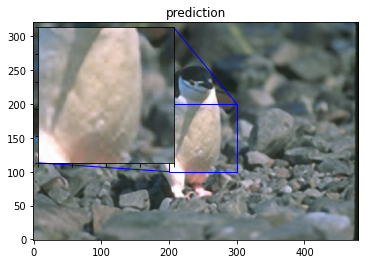

PSNR of predict and high resolution is 29.224


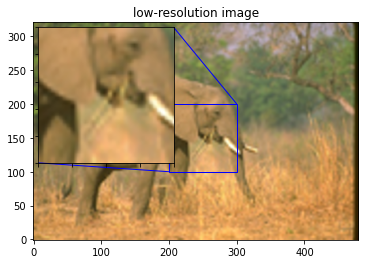

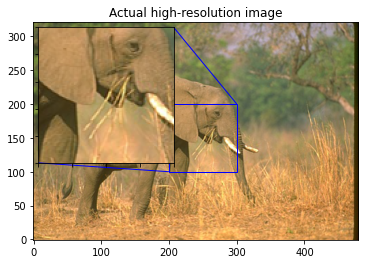

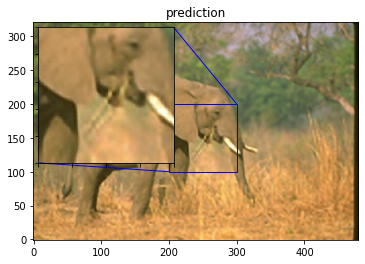

PSNR of predict and high resolution is 25.223


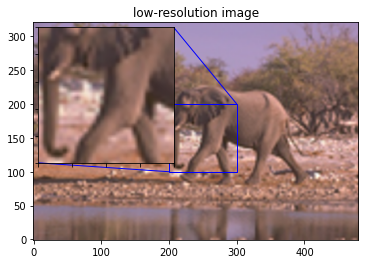

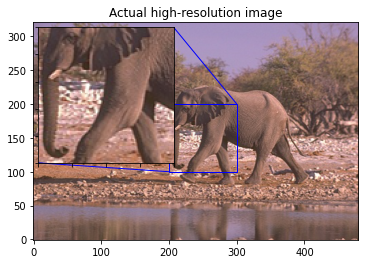

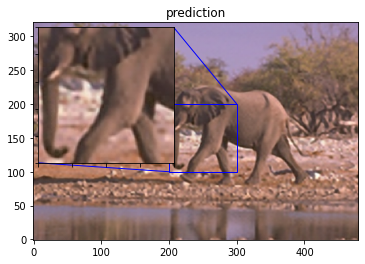

Avg. PSNR of reconstructions is 29.617


In [ ]:
total_test_psnr = 0.0
import random
i = random.randint(0,190)
for index, test_img_path in enumerate(test_img_paths[i:i+10]):  # we'll be running inference model on batch of 5 images
    img = load_img(test_img_path)
    lowres_input = get_low_res_img(img, upscale_factor)
    width = lowres_input.size[0] * upscale_factor
    height = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((width, height))
    lowres_img = lowres_input.resize((width, height))
    prediction = upscale_image(model2, lowres_input)
    test_psnr = tf.image.psnr(img_to_array(prediction), img_to_array(highres_img), max_val=255)

    total_test_psnr += test_psnr

    print("PSNR of predict and high resolution is %.3f" % test_psnr)
    plot_results(lowres_img, index, "low-resolution image")
    plot_results(highres_img, index, "Actual high-resolution image")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of reconstructions is %.3f" % (total_test_psnr / 10))